- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
# Hoja de Trabajo 6 - Modelo de Regresión Logística
                                                                                                                           

In [ ]:
# Librerias
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Estilos
plt.style.use('ggplot')

In [ ]:
# General functions
def calculate_frecuency(data, column, index='index', head = False):
    data_f = pd.DataFrame({
        'frecuency': data[column].value_counts(),
        'relative_frecuency (%)': data[column].value_counts(normalize=True)*100,
        'relative_acc_frecuency': data[column].value_counts(normalize=True).cumsum()
    })
    data_f.reset_index(level=[0], inplace=True)
    data_f.rename(columns={index:column}, inplace=True)
    if head:
        left_aligned_df = data_f.head(20).style.set_properties(**{'text-align': 'center'}) 
    else:
        left_aligned_df = data_f.style.set_properties(**{'text-align': 'center'})
    display(left_aligned_df)
    return data_f


In [ ]:
# General variables
cuantitative = [
    'LotFrontage',
    'LotArea',
    'MiscVal',
	'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'GarageArea',
    'GrLivArea',
    'LowQualFinSF',
    '2ndFlrSF',
    '1stFlrSF',
    'TotalBsmtSF',
    'BsmtUnfSF',
    'BsmtFinSF2',
    'BsmtFinSF1',
    'MasVnrArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'SalePrice',
]

# Exploración de los datos
Análisis exploratorio de los datos para obtener un mejor conocimiento sobre los mismos y su distribución. Se trabajará con un set de datos proporcionado por Kaggle denominado House Prices: Advance Regression Techniques.s.

In [ ]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train_shape = train.shape
test_shape = test.shape

print(f'Los datos de entrenamiento cuenta con {train_shape[0]} observaciones y {train_shape[1]} variables.\nDe igual forma, los datos de prueba tienen {test_shape[0]} observaciones y {train_shape[1]} variables')

Los datos de entrenamiento cuenta con 1460 observaciones y 81 variables.
De igual forma, los datos de prueba tienen 1459 observaciones y 81 variables


In [ ]:
# Resumen de los datos
head = train.head().style.set_properties(**{'text-align': 'center'}) 
display(head)
del head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


Se decidió omitir la parte de exploración de los datos debido a que esta ya ha sido elaborada y presentada en hojas de trabajo anteriores

## Preprocesamiento
Para el preprocesamiento de los datos se procede a validar si existen observaciones con valores faltantes o si es necesaria una normalización de las mismas. Así como la selección de las variables que se utilizaran como predictoras dentro del modelo. Algo importante a tomar en consideración es que debido a que es una regresión logísitica, el modelo solo puede trabajar con variables cuantitativas, por lo tal, como predictores se acotará el rango de variables a únicamente las cuantitativas.

In [ ]:
select_train = train[cuantitative]

### Tratamiento de valores NA


In [ ]:
# Asegurando que no existan valores nan o inf
select_train = select_train[~select_train.isin([np.nan, np.inf, -np.inf]).any(1)]

## Estandarización de las variables

In [ ]:
scaler = StandardScaler().fit(select_train)
train_std = scaler.transform(select_train)

# Datos de entrenamiento y prueba
Selección de las variables a utilizar dentro del modelo de regresión logística, y para ello se utiliza la correlación entre las variables cuantitativas. Por otro lado, también se introducen a las observaciones las variables dicotómicas, determinadas por la clasificación realizada en los árboles de decisión de casas caras, intermedias y económicas.

## Selección de variables
Para seleccionar las variables a utilizar dentro del modelo, se inició tomando en consideración únicamente las variables numéricas. Seguido a esto, se realizó una correlación entre todas las variables cuantitativas para poder analizar cuáles son las que influyen significativamente en el precio de venta, y con base a esto se seleccionó el conjunto de features a utilizar.

In [ ]:
important_correlations = []
corr = train[cuantitative].corr(method='spearman')

for start, h1 in enumerate(cuantitative):
    for h2 in cuantitative[start + 1:]:
        if abs(corr[h1][h2]) > 0.5:
            important_correlations.append((h1, h2, corr[h1][h2]))


data = pd.DataFrame(important_correlations, columns=("Variable1", "Variable2", "Correlación"))
data_f = data.style.set_properties(**{'text-align': 'center'}) 
display(data_f)

del start, h1, h2, corr, data, data_f

,Variable1,Variable2,Correlación
0,LotFrontage,LotArea,0.649633
1,GarageArea,GarageCars,0.853317
2,GarageArea,SalePrice,0.649379
3,GrLivArea,2ndFlrSF,0.642857
4,GrLivArea,FullBath,0.658419
5,GrLivArea,TotRmsAbvGrd,0.827874
6,GrLivArea,GarageCars,0.505094
7,GrLivArea,SalePrice,0.731310
8,2ndFlrSF,HalfBath,0.625272
9,2ndFlrSF,TotRmsAbvGrd,0.587189


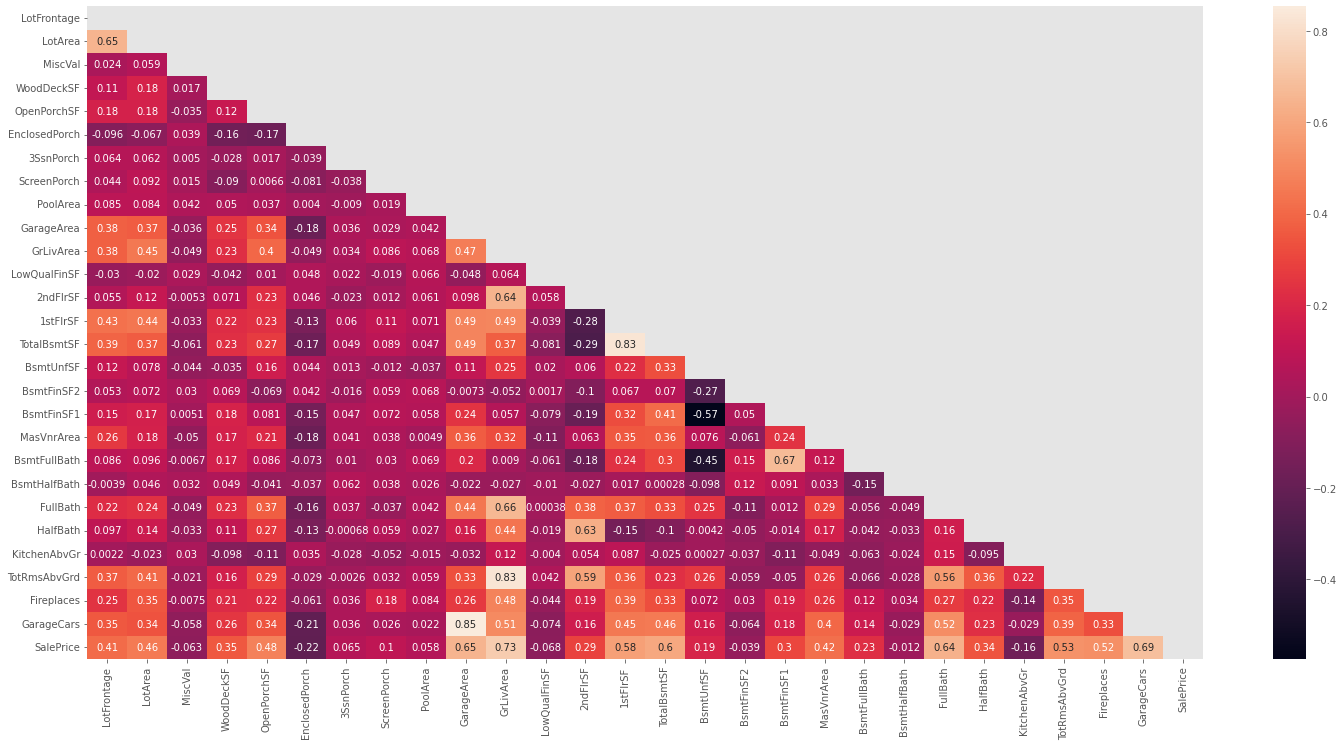

In [ ]:
cuantitative_data = train[cuantitative]
correlation = cuantitative_data.corr(method = 'spearman')
plt.figure(figsize=(25,12))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, cuantitative_data, matrix

Como se puede observar en la tabla y gráfica anterior se presentan aquellas variables que cuentan con una alta correlación (tomando como correlación alta a valores mayores o iguales a 0.5). A continuación se listan la correlaciones encontradas por variables:
- LotFrontage → LotArea
- GarageArea → GarageCars, SalePrice
- GrLivArea → 2ndFlrSF, FullBath, TotRmsAbvGrd, GarageCars, SalePrice
- 2ndFlrSF → HalfBath, TotRmsAbvGrd
- 1stFlrSF → TotalBsmtSF, SalePrice
- TotalBsmtSF → SalePrice
- BsmtUnfSF → BsmtFinSF1, BsmtFullBath
- FullBath → TotRmsAbvGrd, GarageCars, SalePrice
- TotRmsAbvGrd → SalePrice
- Fireplaces → SalePrice
- GargeCars → SalePrice

La estrecha correlación con la que cuentan las variables entre sí representa un potencial error para el modelo, ya que como bien se sabe, uno de los supuestos dentro del modelo de regresión logísticas es que las variables no presenten multicolinealidad ya que esto podría sesgar dicho modelo a la información "repetida" presentada por estas variables. Por lo tal, para evitar un sesgo y *overfitting* del modelo se eliminaran las variables correlacionadas, dejando solo una que represente la información de todas dentro del modelo. Las variables que se descartarán del modelo son:
- LotFrontage
- GarageCars
- TotRmsAbvGrd
- FullBath
- HalfBath
- TotalBsmtSF
- BsmtFinSF1
- BsmFullBath
- Fireplaces


In [ ]:
useless = ['LotFrontage', 
'GarageCars', 
'TotRmsAbvGrd', 
'FullBath', 
'HalfBath', 
'TotalBsmtSF', 
'BsmtFinSF1', 
'BsmtFullBath', 
'Fireplaces', 
'PoolArea', 
'LowQualFinSF', 
'BsmtFinSF2', 
'BsmtHalfBath', 
'KitchenAbvGr' ]

### Variables dicotómicas

In [ ]:
# Agregando la nueva variable al data frame
cheap = [
    (select_train['SalePrice'] <= 171500),
    ]

intermediate = [
    (select_train['SalePrice'] > 171500) & (select_train['SalePrice'] <= 295500),
    ]

expensive = [
    (select_train['SalePrice'] > 295500) 
    ]

values = [1]
select_train['Cheap'] = np.select(cheap, values)

select_train['Intermediate'] = np.select(intermediate, values)

select_train['Expensive'] = np.select(expensive, values)

del values, cheap, intermediate, expensive

In [ ]:
selected_train = select_train.loc[:, ~select_train.columns.isin(useless)]

In [ ]:
expensive_target = selected_train.pop('Expensive')
intermediate_target = selected_train.pop('Intermediate')
cheap_target = selected_train.pop('Cheap')
predictors = selected_train

In [ ]:
# stratified sample for expensive houses
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, expensive_target, train_size  = 0.7, shuffle = True, random_state=19195)

# Regresión logística -Caras-
Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. Muestre el modelo gráficamente. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código.

In [ ]:
model = sm.Logit(endog=target_train, exog=predictors_train, )
model = model.fit()
print(model.summary())

En el resumen del modelo generado anteriormente se puede observar que, en su mayoría, una casa sea clasificada como cara está relacionada negativamente con los predictores seleccionados (esto se puede ver en los coeficientes de la regresión, como LotArea), si bien, existen aquellos en los cuales la relación es positiva, sin embargo esta no es el tipo de relación predominante.

Al igual que en el caso de la regresión lineal, en la regresión logística se puede validar la significancia del modelo creado por medio del LLR p-value, como bien se sabe, el p-value permite conocer la certeza que se espera en los resultados, o el porcentaje que se espera que los resultados no sean correctos. Como se puede observar, el valor obtenido para el modelo es de 3.058e-51 lo que permite asegurar que la regresión puede crear una representación significativa de los datos.

Por otro lado, algo importante a destacar es la significancia de los predictores, al igual que en el caso de la regresión lineal, este se mide por el p-value de cada predictor, y en general se considera que aquellos que tienen un p-value mayor a 0.05 no aportan significativamente al modelo, por lo tal, en busca de mejorar el modelo creado, se eliminaran aquellas variables cuyo p-value este por encima de 0.05.

In [ ]:
new_useless = ['MiscVal', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','GrLivArea', '2ndFLrSF', 'BsmtUnfSF']
predictors_train = predictors_train.loc[:, ~predictors_train.columns.isin(new_useless)]
predictors_test = predictors_test.loc[:, ~predictors_test.columns.isin(new_useless)]

In [ ]:
model = sm.Logit(endog=target_train, exog=predictors_train)
model = model.fit()
print(model.summary())

Al remover del modelo las variables que por su significancia no aportaban información relevante al modelo y entrenar nuevamente el modelo, se puede observar que si bien, el valor de pseudo R-squ ha disminuído en una unidad con respecto al modelo anterior, el p-value también ha disminuído, y con ello garantizando que este modelo tiene un menor porcentaje de otorgar resultados creados al azar.

### Representación gráfica del modelo

In [ ]:
pca = PCA(n_components=1) # 2D projection
principal_components = pca.fit_transform(predictors_train)
pca_train_2d = pd.DataFrame(data = principal_components, columns = ['Predictors'])
display(pca_train_2d.head())
del pca, principal_components
#plot logistic regression curve
sns.regplot(x=pca_train_2d, y=target_train, logistic=True, ci=None)

# Análisis del modelo
Analice el modelo. Determine si hay multicolinealidad en las variables, y cuáles son las que aportan al modelo, por su valor de significación. Haga un análisis de correlación de las variables del modelo y especifique si el modelo se adapta bien a los datos. Explique si hay sobreajuste (overfitting) o no. En caso de existir sobreajuste, haga otro modelo que lo corrija.

### Multicolinealidad y significancia
La multicolinealidad se define como la correlación alta existente entre dos o más variables predictoras. Para esta hoja de trabajo y para este apartado en particular, se considera como correlación alta a aquella correlación con un valor por arriba de 0.85

In [ ]:
correlation = predictors_train.corr(method = 'spearman')
plt.figure(figsize=(12,8))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, matrix

Como se puede observar en el mapa de calor anterior, no existe multicolineal entre las variables utilizadas para entrenar el modelo, ya que desde el apartado de selección de datos de prueba y entrenamiento estos fueron descartados para evitar sesgo.

In [ ]:
model.pvalues

De acorde al valor de significancia, *p-value*, obtenido en el resumen del modelo elaborado se sabe que en ningún caso se acepta la hipótesis nula planteada, la cual indica que el predictor no contribuye al modelo en presencia del resto de predictores. Por lo tal, con base en los *p-value* obtenidos se sabe que todos los *features* aportan significativamente al modelo

### Validación de overfitting
Para validar si en el modelo existe overfitting se realizará un análisis de matriz de confusión para predecir los valores de entrenamiento y los de test creados en apartados anteriores.

In [ ]:
# Predicción con los datos de training
prediction_train = model.predict(predictors_train)
prediction_train = list(map(round, prediction_train))
prediction_test = model.predict(predictors_test)
prediction_test = list(map(round, prediction_test))

In [ ]:
data = pd.DataFrame({
    'Prediction': prediction_train,
    'Real': target_train
})
display(data.head(20))
del data

In [ ]:
plt.style.use('seaborn-dark')
cm_train = confusion_matrix(target_train, prediction_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['No Cara', 'Cara'])
disp.plot()
plt.show()
del cm_train

In [ ]:
plt.style.use('seaborn-dark')
cm_test = confusion_matrix(target_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No Cara', 'Cara'])
disp.plot()
plt.show()

Con los gráficos anteriores se puede inferir que no existe *overfitting* en el modelo, ya que tanto para los datos de entrenamiento como para los datos de prueba, los residuos del modelo no se encuentran distribuídos al azar, sino por su parte, la distribución parece ser en forma de abanico. Ninguna de las 2 predicciones, basado en los gráficos anteriores, parece predecir relativamente, de mejor manera si la casa es cara o no.

# Eficiencia del algoritmo
Utilice el modelo con el conjunto de prueba y determine la eficiencia del algoritmo para predecir el precio de las casas. 

In [ ]:
target_names = ['No cara', 'Cara']
print(classification_report(target_test, prediction_test, target_names=target_names))

En el resumen anterior se puede observar que el modelo es menos preciso al clasificar las casas como caras que como no caras, ya que tan solo el 63% de las predicciones de realizó de manera correcta, a diferencia de las clasificaciones como casas no caras, en las cuales se cuenta con una precisión del 98%. 

Por otro lado, en el caso de la métrica de *recall* esta permite estimar qué tan sensible es el modelo para predecir TODOS los casos correctamente. Es decir, es la habilidad del modelo para encontrar TODAS las casas de un tipo particular. Por ejemplo, en el caso de las casas caras se sabe que del 100% de casas de este tipo, solo pudo clasificar un 76% correctamente. 

Con el *f1_score* es otra forma de evaluar la exactitud del modelo, que incluso en más certera que la exactitud global, ya que esta toma en cuenta la precisión y sensibilidad del modelo. En este caso se puede ver que la exactitud en cuanto al *f1_score* para la clasificación de una casa como caras es de 69%, lo cual no es un valor muy alto, pero al menos asegura que es mejor que hacer predicciones al azar.

Es interesante notar que a pesar de que el modelo no sea muy bueno prediciendo las casas de tipo caras, este cuenta con un *accuracy* del 95% lo cual en general indica que el modelo es bueno prediciendo los datos, sin embargo es importante indicar que este valor no toma en consideración los sesgos que puedan existir en los datos. Es por ello que mejor se mide la exactitud del modelo mediante el *f1-score*.

In [ ]:
disp.plot()
plt.show()

Con la matrix de confusión mostrada anteriormente es fácil notar que el modelo se equivocó más en reconocer si una casa es cara  en contraste con reconocer que una casa no sea cara. Esto puede deberse a que dentro del data set de entrenamiento se tenía una mayor cantidad de casas no caras que de caras, por lo que el modelo aprendió a recnocer este tipo de casas más fácilmente. Por otro lado, también se puede notar cómo la sensibilidad o *recall* está asociado a la cantidad de errores que comete en las predicciones, está estrechamente relacionada con la información mostrada por la matriz de confusión. 

Los errores dentro del modelo dan la capacidad de encontrar estrategias que permitan entrenar de mejor forma el mismo, como se mencionó anteriormente los errores dentro del conjunto de datos pueden ser consecuencia del sesgo obtenido en los datos, por lo tal, una forma de asegurar un mejor aprendizaje por medio del modelo sería realizar una muestro balanceado.